# BMI6016 - Data Wrangling
# Spatial and Temporal Analysis of Influenza Virus Occurrence

| Name | E-Mail | UID |
| ---- | ------ | --- |
| Hannah Van Hollebeke | vanhollebeke.hannah@gmail.com | u0697848 |
| Kolton Hauck | kolton.hauck@utah.edu | u1019364 |
| Sukrut Shishupal | sukrut.shishupal@utah.edu | u1401898 |
| Nick Patterson | Nicholas.Patterson@utah.edu | u6020304 |
| Vladimir Vinnik | v.vinnik@utah.edu | u6028096 |

## Background and Motivation

Influenza viruses are constantly evolving by undergoing genetic changes over time through genetic drift or recombination events. The WHO Global Influenza Surveillance and Response System (GISRS) conducts year-round surveillance of circulating influenza strains to monitor changes in the genome of these viruses. The information collected by the GISRS from studying influenza genome trajectory plays an important role in public health by helping to determine whether current vaccines and antiviral drugs are effective against circulating influenza strains or if there is a need to develop new treatments [1]. 

Influenza viruses have been responsible for some of the deadliest pandemic events in human history and the nature of its genome plasticity and abundance of natural hosts make it a perpetual threat [2]. Genomic sequencing has led to profound insights into the global pattern identification of circulating and evolving Influenza virus. These data are available online and can be used to visualize global sequence trajectories which can help us understand the spread of the Influenza virus and the changes in its genome over time and geographic location [3,4]. Given the global impact that viruses have had in recent years, government agencies and corporations worldwide have invested enormous resources to study the origins of pandemics and mitigate their effects on society. Therefore, learning how to work with viral genomic data is an important skill for a modern data scientist interested in this type of research. 
 

## Project Description

### Objective

The primary goal is to prepare data that show incidence of human-associated influenza A strain subtypes with a temporal component and provide the geographic location of countries across the globe where those subtype isolates were documented. The data will contain information regarding all H and N subtypes, as some of the most severe antigenic responses in humans are due to subtypes for which the natural reservoirs are other animals. The dataset would allow for connections between avian, swine, and human influenza subtypes. Additionally, the data would include a linkage to the isolate assignments for the relevant subtypes and the origin of the sequence data. These goals will be accomplished using publicly available influenza data from GISAID and NCBI [3,4,5].  

These data could subsequently be used for a wide variety of research purposes dealing with analysis of the influenza genome. Potential useful information that could be gleaned includes mutational frequency, genomic location, and type (SNPs, duplications, recombination). These parameters could also be evaluated in a temporal and geographic context. Throughout the course of this project, we hope to become familiar with the fundamentals of data practices in this field and how to prepare these data to facilitate downstream analysis. 

### Dataset Information

Influenza A genomes and associated information will be obtained from GISAID or NCBI Influenza Database [3,4,5]. GISAID has a total of 348,530 Influenza A viruses and 1,627,175 sequences due to the segmented genome. The GISAID database organization runs analyses on the dataset that can be found here: https://gisaid.org/database-features/influenza-genomic-epidemiology/. By creating an account and logging in, the sequence and associated data can be directly downloaded. The download limit is 20,000 viruses and will therefore need to be executed in batches. 

An alternate data source is the NCBI Influenza virus database which has a similar dataset: https://www.ncbi.nlm.nih.gov/genomes/FLU/Database/nph-select.cgi?go=database 

Supplementary data may be added to the dataset as needed to enrich the information and/or provide more confidence in the data quality. An example dataset could be WHO data such as found here: https://www.who.int/news-room/events/detail/2023/02/20/default-calendar/who-consultation-on-the-composition-of-influenza-virus-vaccines-for-use-in-the-2023-2024-northern-hemisphere-influenza-season. These data estimate global infection rates, among other information. 


## Project Implementation
The scope of this project is to prepare a dataset for an analysis for tracking the trajectory of influenza sequence variations. To accomplish this, we want to understand the data structure and composition, assess the data quality as it relates to the intended use, and perform some exploratory analysis and visualizations to gain an understanding of the major trends and relationships.  

### Imports

!pip install cmasher

In [1]:
#!pip install cmasher

# Data manipulation
import pandas as pd
import numpy as np
import math

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from ipywidgets import interact
import ipywidgets as widgets
import folium
from IPython.display import display
from geopy.geocoders import Nominatim, Bing

ModuleNotFoundError: No module named 'geopy'

In [ ]:
# To hide the future warnings for conciseness
import warnings
warnings.filterwarnings('ignore')

# Import data
raw_data = pd.read_csv("gisaid_epiflu_isolates_human.csv")

## Data Cleaning
This section outlines how the raw data was processed for the final cleaned dataset.

In [ ]:
# Data types and null value counts
raw_data.info()

The size of the data is about 300,000 virus isolates and 64 columns. Most attributes are categorical and several have missing values. 

The drug resistance data does not have any missing values, however, a quick glance through the data shows 'Unknown' values for many isolates. The counts for these are shown below. These unknown values are plotted below, conconverted to null values, and teh 

In [ ]:
# Get counts for all value types for drug resistance data
raw_data.iloc[:, 31:41].apply(pd.value_counts)

In [ ]:
# Create a dictionary to hold the counts of 'Unknowns' for each column
counts = {}
for column_name in raw_data.columns:
    column = raw_data[column_name]
    count = (column == 'Unknown').sum()
    counts[column_name] = count

# Convert the dictionary to a pandas Series and plot a bar graph
plt.figure(figsize=(15, 10), dpi=80)
counts_series = pd.Series(counts)
counts_series.plot(kind='barh')
plt.xlabel('Column')
plt.ylabel('Unknowns')
plt.title('Count of Unknown in Each Column')
plt.show()

# Much of the drug resistance data is unknown. Convert to NaN values. 
mod1 = raw_data.copy()
mod1.replace('Unknown', np.nan, inplace = True)

# Get null value totals
null = mod1.isnull().sum()
plt.figure(figsize=(15, 10), dpi=80)
null.plot(kind='barh')
plt.title('Null Value Counts After Unknowns Converted to Null Values')
plt.xlabel('Null Value Count')
plt.ylabel('Column Name')
plt.show()

In [ ]:
# Get counts for all value types for drug resistance data
raw_data.iloc[:, 31:41].apply(pd.value_counts)

The final dataset will use a subset of these attributes. However, to preserve some of the information for potential use in analysis, we split the data into different types of information. These could be written to csv files if needed at any step of an analysis. 

In [ ]:
# Sample info. Information regarding the submitting party and sample collection
sample_info_columns = ['Isolate_Id', 'Isolate_Submitter', 'Submitting_Lab', 'Authors', 'Publication',
                       'Originating_Lab', 'Submitting_Sample_Id', 'Originating_Sample_Id', 'Passage_History',
                       'Note', 'PMID', 'Submission_Date', 'Update_Date']
sample_info = raw_data[sample_info_columns]

# Phenotype info. Information regarding virus characteristics 
phenotype_info_columns = ['Isolate_Id', 'Antigen_Character', 'Animal_Vaccin_Product', 'Adamantanes_Resistance_geno',
                  'Oseltamivir_Resistance_geno', 'Zanamivir_Resistance_geno', 'Peramivir_Resistance_geno',
                  'Other_Resistance_geno', 'Adamantanes_Resistance_pheno', 'Oseltamivir_Resistance_pheno',
                  'Zanamivir_Resistance_pheno', 'Peramivir_Resistance_pheno', 'Other_Resistance_pheno']
phenotype_info = raw_data[phenotype_info_columns]

# Patient info. Information regarding the human host demographics and epidemiology
patient_info_columns = ['Isolate_Id', 'Host_Age', 'Host_Age_Unit', 'Host_Gender', 'Patient_Status', 'Zip_Code', 
                'Is_Vaccinated', 'Human_Specimen_Source', 'Outbreak', 'Pathogen_Test_Info' ,'Animal_Specimen_Source',
                'Animal_Health_Status', 'Domestic_Status']
patient_info = raw_data[patient_info_columns]

# Genbank info. Links to genbank accession numbers if available for each segment per isolate ID
genbank_columns = ['Isolate_Id', 'PMID', 'PB2 INSDC_Upload', 'PB1 INSDC_Upload', 
                   'PA INSDC_Upload', 'HA INSDC_Upload', 'NP INSDC_Upload', 
                   'NA INSDC_Upload', 'MP INSDC_Upload','NS INSDC_Upload', 
                   'HE INSDC_Upload', 'P3 INSDC_Upload']

# GISAID genomic info. Links the isolate id to the segment ids which would 
segments = ['Isolate_Id', 'PB2 Segment_Id', 'PB1 Segment_Id', 'PA Segment_Id', 
            'HA Segment_Id', 'NP Segment_Id', 'NA Segment_Id', 'MP Segment_Id', 
            'NS Segment_Id']
segment_ids = raw_data[segments]

# HE and P3 segments are specific to influenza C which we are not including. These are removed entirely.
# 'HE Segment_Id', 'P3 Segment_Id'

cols = ['Isolate_Id', 'Isolate_Name', 'Subtype', 'Location', 'Collection_Date', 'Lineage']

mod2 = mod1[cols]

mod2.head()

After column selection, view the missing values for the remaining columns

In [ ]:
null = mod2.isnull().sum()
plt.figure(figsize=(10, 3), dpi=80)
null.plot(kind='bar')
plt.title('Null Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.show()

The only missing values are the lineage assignments. For influenza A, the subtypes are the main classification we are interested in. The lineage assignment further classifies the subtypes when applicable. For influenza B, the lineage differentiates the two clades of influenza B viruses, however, some are unclassifed. 

The remaining data cleaning will filter the data to fit the intended purpose and parse the columns to facilitate easier data manipulation. 

In [ ]:
# Filter the data frame to remove C subtypes. Influenza C infections in humans are uncommon and less severe. Influenza C also has different genome segmentation. 
mod3 = mod2.loc[mod2['Subtype'] != 'C']

# Adding two new columns to the existing dataframe based on the subtype value by splitting the string 
mod3['Species'] = mod3.Subtype.str.split('/', expand=True)[0]

# unique values after split
print('after split, before strip: ', mod3['Species'].unique())
mod3['Species'] = mod3['Species'].str.strip()
# Adding two new columns to the existing dataframe.
# bydefault splitting is done on the basis of single space.
try:
    mod3['Type'] = mod3.Subtype.str.split('/', expand=True)[1]
    print('after split, before strip: ', mod3['Type'].unique())
    mod3['Type'] = mod3['Type'].str.strip()
except:
    mod3['Type'] = None

# To verify that the unique values do not have extra spaces in them
print('after strip: ', mod3['Species'].unique())
print('after strip: ', mod3['Type'].unique())

# Split to location columns
mod3['Continent'] = mod3.Location.str.split('/', expand=True)[0]
mod3['Continent'] = mod3['Continent'].str.strip()
# Adding two new columns to the existing dataframe.
# bydefault splitting is done on the basis of single space.
try:
    mod3['Country'] = mod3.Location.str.split('/', expand=True)[1]
    mod3['Country'] = mod3['Country'].str.strip()
except:
    mod3['Country'] = None

try:
    mod3['Region'] = mod3.Location.str.split('/', expand=True)[2]
    mod3['Region'] = mod3['Region'].str.strip()
except:
    mod3['Region'] = None

# To verify that there isn't extra whitespace and that the split worked correctly
print(mod3['Continent'].unique())
print(mod3['Country'].unique()[0:10])
print(mod3['Region'].unique()[0:10])

# Split the date into year, month, and day columns. The day column can be dropped
mod3['Collection_Year'] = mod3.Collection_Date.str.split('-', expand=True)[0].astype('Int64')
# Adding two new columns to the existing dataframe.
# bydefault splitting is done on the basis of single space.
try:
    mod3['Collection_Month'] = mod3.Collection_Date.str.split('-', expand=True)[1].astype('Int64')
except:
    mod3['Collection_Month'] = np.nan

print(mod3['Collection_Year'].unique(), type(mod3['Collection_Year'][0]))
print(mod3['Collection_Month'].unique(), type(mod3['Collection_Month'][0]))

# identify unique lineage names and counts
lineage_counts = mod3['Lineage'].value_counts(dropna = False)
print('Lineage value counts: \n', lineage_counts)

# add binary column for each lineage
# prepopulated the whole column with zeros
mod3['pdm09'] = False
mod3['Victoria'] = False
mod3['Yamagata'] = False
mod3['seasonal'] = False

# loop through and replace with 1 or None based on lineage value
for i, virus in enumerate(mod3['Lineage']):
    if virus == 'pdm09':
        mod3.at[i, 'pdm09'] = True
    elif virus == 'Victoria':
        mod3.at[i, 'Victoria'] = True
    elif virus == 'Yamagata':
        mod3.at[i, 'Yamagata'] = True
    elif virus == 'seasonal':
        mod3.at[i, 'seasonal'] = True
    elif virus is np.NaN:
        mod3.at[i, 'pdm09'] = -1
        mod3.at[i, 'Victoria'] = -1
        mod3.at[i, 'Yamagata'] = -1
        mod3.at[i, 'seasonal'] = -1

print('\npdm09 value counts: \n', mod3['pdm09'].value_counts(), type(mod3['pdm09'][0]))

# drop parsed columns. Leaving original lineage column in, it might be easier to label things that way.
cleaned = mod3.drop(['Collection_Date', 'Subtype', 'Location'], axis = 1)
cleaned.head()
cols = cleaned.columns

# reorder the columns
cleaned = cleaned[['Isolate_Id', 'Lineage', 'Species', 'Type',
       'Continent', 'Country', 'Region', 'Collection_Year', 'Collection_Month',
       'pdm09', 'Victoria', 'Yamagata', 'seasonal', 'Isolate_Name']]

cleaned.info()
cleaned.head()

The parsing step created some extra white space which was removed in the final dataset. Unique values for some of the columns are printed above to confirm that the data is plausible. Extra columns were dropped and the remaining columns were reordered. 

The final dataset is written to a csv file for to be imported and used for the explotatory analysis and visualizations. The data information is printed to view the datatypes and column features of the cleaned data. 

In [ ]:
# Final cleaned main dataset for analysis
cleaned.to_csv('cleaned_data_20230401.csv', index = False)

In [ ]:
# Summarize data types and other info
dtype = cleaned.dtypes.reset_index(name='data_types').rename(columns={'index' :  'Column'}).set_index('Column')

describe = cleaned.astype('object').describe().transpose()
describe = pd.DataFrame(describe)

data_info = pd.merge(dtype, describe, left_index = True, right_index = True).iloc[1:, :]

data_info.head(15)

A supplementary csv file is written that links the isolate to the genomic data. Due to the segmented genome, each isolate may be associated with a fasta file for each genomic segment. This may assist in any downstream genomic analysis that this data is used for.

In [ ]:
# For each isolate id, a segment id is provided if there is genomic data present. This would link to the fasta file header.
segment_ids.to_csv('segment_ids.csv', index = False)
segment_ids.head()

# Data Quality Assessment

The quality of the data used in this project were assessed using the framework laid out in the paper titled 'Methods and dimensions of electronic health record data quality assessment: enabling reuse for clinical research', by Weiskopf, and Weng. This paper discusses 5 important components for determining the quality of a dataset. These components are: Completeness, Correctness, Concordance, Plausibility, and Currency. Completeness is a measure of whether or not the data is fully available, or how much data is missing. Correctness is a measure of whether or not the data contained in a dataset are true or not. Concordance in a dataset measures agreement between all the data domains contained in a dataset. Plausibility is a measure of whether or not the data fall within a reasonable expected range in a given data domain, and Concordance is a measure of whether the data captures the truth about an element at a particular moment in time. 

### Data Quality Before Wrangling

Based on this framework for assessing data quality, the initial dataset was of fair quality. The most glaring issue with the original dataset was with the large number of missing values. As demonstrated previously, there were quite a few columns that were missing data for most or all of the samples, such as the columns containing information about drug resistance. Becuase of this, the original dataset had a very low score for completeness. The next component in the data quality assessment, Correctness, suffers from the lack of completeness in the data. Some of the information recorded in this dataset, such as the segment data, is useful for verifying other values, such as the lineage or subtype of the viral samples. Because these values have such as high degree of missingness, in many cases verification will not be possible. Because of this, the Correctness score for this dataset is slightly lowered. The next component, Concordance, measures whether all the data elements in a dataset match up. This component also suffers from the large number of missing values because it is difficult to determine if different data elements agree if they are missing. An example is again that it is difficult to determine if the recorded lineage for a sample matches up with the genetic information if that information is missing. The dataset does score well for the last two components, Plausibility and Currency. The data contained in this dataset do appear to be plausible. All of the values recorded for influenza strain and subtype are known values. The range of dates for sample collection also appear to make sense, ranging from the year 1905 to 2022. As far as can be determined the dataset scores well for Currency, as there is a submission data recorded for almost every entry. The only issues with Currency in this dataset is that there is a value for submission date aswell as Update date. It is difficult to know whether or not the values contained in other columns contain information from the original submission date or the update date. For this reason the Currency score suffers slightly. 

### Data Quality After Wrangling

After this dataset was processed, the data was now of Good quality. The component with the largest difference between the initial dataset and the wrangled dataset was in Completeness. As previously discussed, the original dataset was missing a very large number of values. In the wrangled dataset, all but one of the data elements contained no missing values. The only element containing any missing values is the Lineage column. The Correctness of the wrangled data still suffers from the same issue as the original dataset, and that is that some of the values that are no longer recorded in the dataset could be useful for verifying information contained in some elements, such as the sample subtype. The Concordance of the wrangled dataset is high. There are no values in this dataset that contradict one another. Similar to the origianl dataset, the wrangled dataset has a high score for Plausibility. The range of year values is the same in this final dataset, and the values for species and type of influenza are again all known values. Similar to the original dataset the wrangled dataset scores well for Currency. This final dataset does not contain two separate columns for submission date and an update date, leading to less confusion. 

One final element that is important to note with regards to data quality that is not contained in the framework laid out in the paper used here is that of usability for the intended analysis. This is another area in which the processed dataset is an improvement over the original. The proposed analysis which this data was prepared for is to track the appearance of various strains of influenza virus over time and geographic location. The original dataset contained the date in one column and the entirety of the geographic information in another. In the final dataset, these values are now separated out into multiple columns each. The date information is in two columns, one for month and one for year, while the geographic data is stored in columns for continent, country and region. These changes will make the dataset more suitable for the proposed analysis becuase they allow for different levels of granularity. In carrying out the analysis fewer steps will be required to determine in which month different samples appeared than it would be when using the original dataset. Similarly, it would be easier to track the appearance of different strains across different levels of geography, such as country vs region, with the wrangled dataset than with the original. Because of these changes the wrangled dataset is more suitable for the proposed analysis than the original. 

## Exploratory Data Analysis (EDA)

Exploratory data analysis was done to investigate the dataset and perform some preliminary analyses, and act as another way to validate the data quality of the dataset. Primarily, EDA (along with the other Visualizations done later) was done to act as a proof of concept to determine if this dataset is indeed usable for it's intended purpose.

In [ ]:
#read in the file and add 'datetime' col to dataset
df =  pd.read_csv('cleaned_data_20230401.csv')
df['Date'] = pd.to_datetime({'year': df['Collection_Year'], 'month': df['Collection_Month'], 'day': 1})
df.head()

#### Static Distributions and plots

First shown are some bar graphs that show the distributions of lineages across continents and species using the whole dataset.

We also graphed the number of isolates, faceted by lineage, across time for the United States and the whole world. This graph is important in showing that we can look at, and perform analyses on, the dataset from a time-series viewpoint, and more specifically, a broad viewpoint across time. We can also differentiate, or group-by, different countries and compare countries this way. Since region and continent are other features included in the dataset, we could differentiate by these factors as well. 

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=False)

sns.histplot(data=df[['Lineage', 'Species']].dropna(), x='Lineage', hue='Species', multiple='stack', ax=axes[0]).set(title='Lineages and Species')

sns.histplot(data=df[['Lineage', 'Continent']].dropna(), x='Lineage', hue='Continent', multiple='stack', ax=axes[1]).set(title='Lineages across continents')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharey=True)

sns.lineplot(data=df[(df['Collection_Year'] > 2000) & (df['Country'] == 'United States')].groupby([pd.Grouper(key='Date', freq='M'), 'Lineage'], as_index=False)[['Lineage', 'Date', 'Isolate_Id']].size(),
             x='Date',
             y='size',
             hue='Lineage',
             hue_order=['Yamagata', 'seasonal', 'Victoria', 'pdm09'],
             ax=axes[0]).set(title='Number of isolates for United States')

sns.lineplot(data=df[df['Collection_Year'] > 2000].groupby([pd.Grouper(key='Date', freq='M'), 'Lineage'], as_index=False)[['Lineage', 'Date', 'Isolate_Id']].size(),
             x='Date',
             y='size',
             hue='Lineage',
             hue_order=['Yamagata', 'seasonal', 'Victoria', 'pdm09'],
             ax=axes[1]).set(title='Number of isolates Globally')

#### Interactive plots

The static plots are useful in getting a broad scope, idea or perspective on the dataset. However, in order to look at a specific year, or year ranges, it would be difficult and tedious to make graphs for each year and analyze them individually. Instead, we were able to make an interactive plot, with a slider where we can easily pick which year we would like to look at. This makes it much easier to look at individual years and look at different aspects, such as total distributions of lineage and species, or a line graph showing the number of isolates across the year. Here, the interactive graph has four plots: a line graph showing the number of isolates for each lineage across the whole year, a violin plot which shows the distributions of isolate counts for each continent, and barcharts showing the total distributions of subtypes and lineages across the whole year for individual continents.

This plot currently only allows a single year to be selected, but could easily be expanded to be able to select a range of years and months, allowing more flexibility and ease of analysis of the dataset.

In [ ]:
#initialize year
year = 2020

#function to update interactive plot
def update_plot(year):
    curr_df = df[df['Collection_Year'] == year]
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=False)

    #subplot 1
    sns.lineplot(data=curr_df.groupby([pd.Grouper(key='Date', freq='M'), 'Lineage'], as_index=False)[['Lineage', 'Date', 'Isolate_Id']].size(),
                 x='Date',
                 y='size',
                 hue='Lineage',
                 hue_order=['Victoria', 'Yamagata', 'pdm09', 'seasonal'],
                ax=axes[0][0])

    #subplot 2    
    vp = sns.violinplot(data=curr_df,
                   x='Collection_Month',
                   y='Continent',
                   scale='count',
                   cut=0,
                   order=['North America', 'Asia', 'Africa', 'Europe', 'South America', 'Oceania'],
                    ax=axes[0][1]
                  )

    vp.set_xticks(range(1,13))

    #subplot 3
    sns.histplot(data=curr_df[['Type', 'Continent']].dropna(),
                 x='Type',
                 hue='Continent',
                 multiple='stack',
                 #palette=palette,
                 cumulative=True,
                 hue_order=['North America', 'Asia', 'Africa', 'Europe', 'South America', 'Oceania'],
                 ax=axes[1][0]
                )#.set(title=f'Types across continents, year: {year}')

    #subplot 4
    sns.histplot(data=curr_df[['Lineage', 'Continent']].dropna(),
                 x='Lineage',
                 hue='Continent',
                 multiple='stack',
                 #palette=palette,
                 cumulative=True,
                 hue_order=['North America', 'Asia', 'Africa', 'Europe', 'South America', 'Oceania'],
                 ax=axes[1][1],
                 legend=False
                )#.set(title=f'Lineages across continents, year: {year}')

#add slider
slider = widgets.IntSlider(min=2000, max=2023, description='Year')
ui = widgets.HBox([slider])

out = widgets.interactive_output(update_plot, {'year': slider})

#display interactive plot
display(ui, out)

In [ ]:
# Import data
data = pd.read_csv("cleaned_data_20230401.csv").iloc[:, 1:]

# convert dates to Int64 so that they will appear as integers and handle the missing values
# the default converts them to floats because of the missing values
data['Collection_Year'] = data['Collection_Year'].astype('Int64')
data['Collection_Month'] = data['Collection_Month'].astype('Int64')

# Merge the species, subtype, and lineage info to a single column, remove extra info as needed
data['subtype'] = data['Species'].map(str) + '_' + data['Type'].map(str) + '_' + data['Lineage'].map(str)
data['subtype'] = data['subtype'].replace(['_nan', '_seasonal', 'A_'],'', regex = True)

Formatting the dates and subtype columns to visualize.

In [ ]:
# Geographical plot for total counts per country
# region and country counts
counts = data.groupby(['Species', 'subtype'], dropna = False, as_index = False).size()
counts = counts.sort_values('size', ascending = True).set_index('subtype')

low_count = counts.loc[counts['size'] <= 100]
print('The following lineages are represented 10 or fewer times in the dataset:\n\n', list(low_count.index))

In [ ]:
# Remaining Lineages Composition in Dataset
high_count = counts.loc[counts['size'] > 100]

plt.figure(figsize = (12, 6))
plt.barh(high_count.index, high_count['size'], height = 0.8, color = 'purple')
plt.margins(0.08, 0.01)
for index, value in enumerate(high_count['size']):
    plt.text(value, index,
             '  ' + str(value), va = 'center', color = 'blue')
plt.title('Total Subtype and Lineage Counts For All Data')
plt.xlabel('Count if > 10')
plt.show()

In [ ]:
# proportion of subtypes documented over decades. proportions chart and total data counts, not separated by location.
# geographical plot for total counts per country
# region and country counts
time = data.groupby(['subtype', 'Collection_Year'], dropna = False, as_index = False).size().set_index('subtype')
keep = set(time.index) - set(low_count.index)
time = time.loc[list(keep)].reset_index().sort_values('size', ascending = False)
time['decade'] = time['Collection_Year'] - (time['Collection_Year']%5)
time = time[['subtype', 'decade', 'size']].groupby(['subtype', 'decade'], dropna = False, as_index = False).sum()
time['subtype_total'] = time['size']
time = time.sort_values('size', ascending = False)

time.head()

In [ ]:
# Pivot the dataframe by the 5-year interval and get proportions for each subtype per time interval. 
time_pivot = time.pivot_table(index=['subtype'], columns=['decade'], aggfunc=sum, values = ['size']).fillna(0)
time_pivot = time_pivot.div(time_pivot.sum(0), axis=1)

plt.figure(figsize = (12, 6))
sns.heatmap(time_pivot, robust = True, cmap = 'viridis')

time_pivot.head()

In [ ]:
# Segment completeness analysis
seg_ids = pd.read_csv('segment_ids.csv')

seg_tf = seg_ids.iloc[:, 1:].notnull().astype('int')
seg_tf['total'] = seg_tf.sum(axis = 1)
seg_tf.loc['total'] = seg_tf.sum(axis = 0)

seg_tf = seg_tf.sort_values(by = 'total', ascending = False).sort_values(by = 'total', axis = 1, ascending = False)
seg_tf = seg_tf.iloc[1: ,  :]

seg_tf.columns = [col.split(maxsplit = 1)[0] for col in list(seg_tf.columns)]
print(seg_tf.columns)

cmap = cmr.get_sub_cmap('PuRd', 0.1, 1.0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [.1, .9]})

sns.heatmap(seg_tf[['total']], ax = ax[0], yticklabels = False, cmap = 'PuRd')
sns.heatmap(seg_tf.iloc[:, 1:], ax = ax[1], yticklabels = False, cmap = 'PuRd')

ax[0].set_xlabel('Segment Count Per Isolate')
ax[0].set_ylabel('Isolate ID')
ax[0].set_title('Total Segments')

ax[1].set_xlabel('Genomic Segment (Present: 1 or Absent: 0)')
ax[1].set_title('Segment Completeness')

## Visualization

In the visualization part, we created two types of maps, one was a world map which had multiple cities and variant names plooted in it. The second map was a choropleth map which showed the density of patients based on country. 

We used folium and geo pandas library to plot the two maps. The world map is an interactive map, so we can click on the point on the graph and check the variant name accordingly. 

In [ ]:
one = df[['Country', 'Collection_Year', 'Type']]
one = one.dropna()
one

In [ ]:
# Create a Bing geocoder object with your Bing Maps API key
geolocator = Bing(api_key='API-KEY-HERE')

# Create a Folium Map object
world_map = folium.Map(location=[0, 0], zoom_start=2)

# Define a function to get coordinates for a location
def get_coordinates(location):
    try:
        geo_location = geolocator.geocode(location)
        latitude = geo_location.latitude
        longitude = geo_location.longitude
        return [latitude, longitude]
    except Exception as e:
        print(f'Error getting coordinates for {location}: {e}')
        return None

# Add markers for each country and region
for index, row in one.iterrows():
    coords = get_coordinates(row['Country'])
    if coords:
        # Convert Type value to string and concatenate with ' - '
        type_str = str(row['Type']) if pd.notna(row['Type']) else ''
        folium.Marker(location=coords, popup=row['Country'] + ' - ' + type_str).add_to(world_map)

# Define a function to update the map based on the selected year
def update_map(year):
    filtered_data = one[one['Collection_Year'] == year]
    world_map = folium.Map(location=[0, 0], zoom_start=2)
    for index, row in filtered_data.iterrows():
        coords = get_coordinates(row['Country'])
        if coords:
            type_str = str(row['Type']) if pd.notna(row['Type']) else ''
            folium.Marker(location=coords, popup=row['Country'] + ' - ' + type_str).add_to(world_map)
    display(world_map)  # Display the updated map

# Get unique years for the year widget
years = one['Collection_Year'].unique()

# Create a widget for selecting the year
year_widget = widgets.Dropdown(options=years, description='Year:', style={'description_width': 'initial'})

# Define a callback function for the widget
def on_year_change(change):
    update_map(change.new)

# Attach the callback function to the widget
year_widget.observe(on_year_change, names='value')

# Display the initial map and year widget
display(world_map)
display(year_widget)

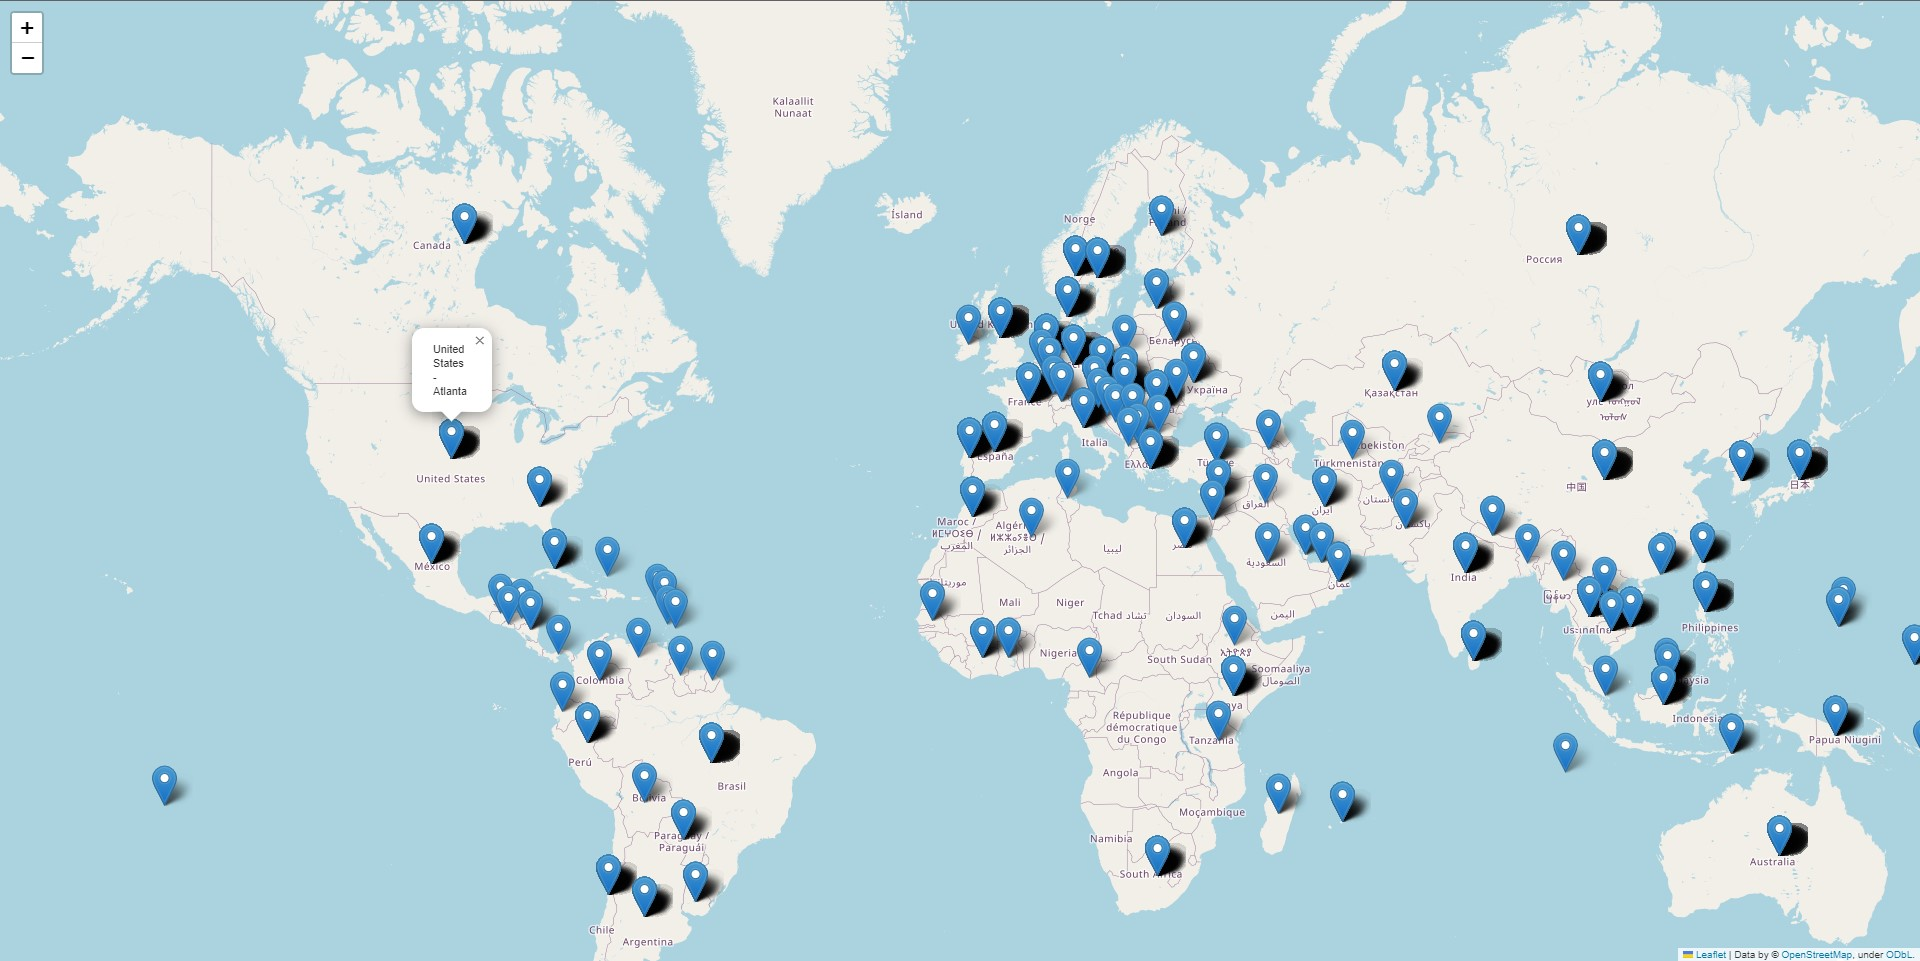

As we can see in the screenshot, whenever we click on a point on the map, we get a interactive pop-up which shows the country and city name. 

In [ ]:
# Specify a different file path to save the map HTML file
file_path = 'C:/Users/sukru/Downloads/cleaned_data_20230401/world_map.html'

# Save the map as an HTML file in the specified file path
world_map.save(file_path)

CHOROPLETH

In [ ]:
df = pd.read_csv("VIW_FID_EPI.csv")
d = df[['ILI_OUTPATIENTS', 'COUNTRY_AREA_TERRITORY', 'ISO_YEAR']]
d.dropna()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas.tools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, widgets

# Read the dataframe
df = d

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define function to create choropleth map
def create_choropleth(year):
    # Filter data based on selected year
    filtered_df = df[df['ISO_YEAR'] == year]

    # Merge world shapefile with filtered dataframe
    merged = world.merge(filtered_df, left_on='name', right_on='COUNTRY_AREA_TERRITORY')

    # Create a choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    merged.plot(column='ILI_OUTPATIENTS', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

    # Add labels to the map
    merged.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)

    ax.set_title(f'ILI Outpatients by Country - {year}')
    plt.show()

# Create an interactive year selection widget
year_slider = widgets.IntSlider(min=df['ISO_YEAR'].min(), max=df['ISO_YEAR'].max(), step=1, description='Year:')
interact(create_choropleth, year=year_slider)

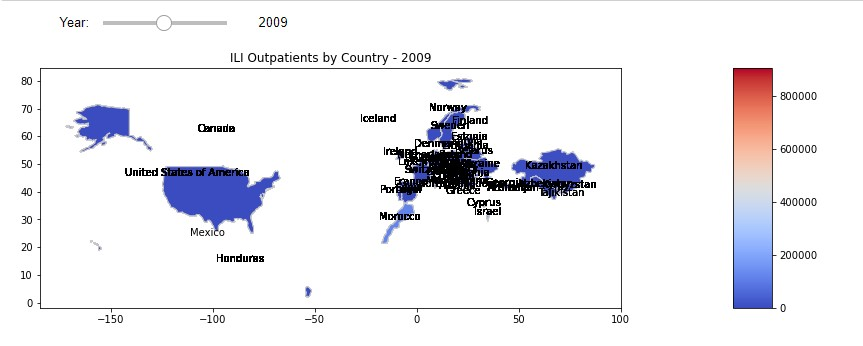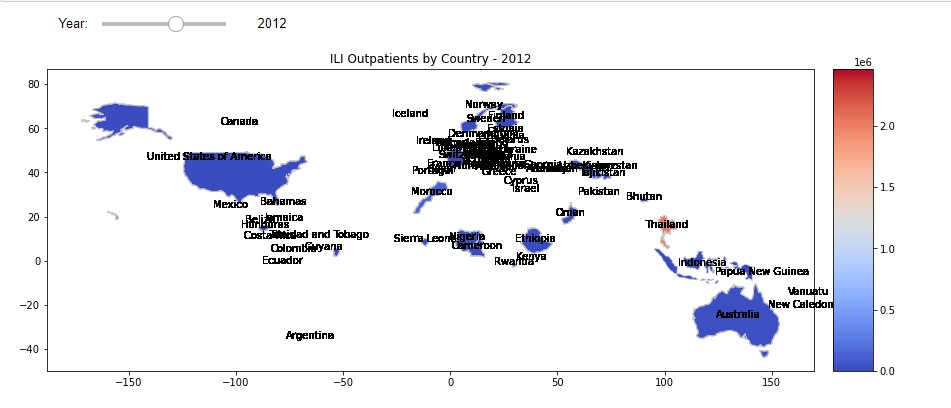

We created the choropleth map using geo pandas library. We also used the ipywidgets to create a slider to change the years. 
Since 2009 was a pandemic year, we were not able to capture that properly. This is maybe due to fact that there were lot of missing values in the dataset. 
In 2012, we can see a slight increase in cases in Thailand.  

## Discussion and Conclusions
Based on the data quality assessment, we found that there are some gaps in the dataset. After data cleaning, however, the most essential features for our purpose have high completeness. The data wrangling steps parsed some columns into separate attributes to make filtering and exploring the data easier for this analysis. The wrangled data will also facilitate subsetting the fasta files associated with the dataset for any downstream genomic analysis. 

Through some preliminary data exploration, we looked at spatial and temporal trends in the dataset. One major finding is that the geographical representation is quite skewed towards westernized countries. For example, there are relatively few sequences Africa compared to Europe and North America. Additionally, the data quantity changes significantly once sequencing becomes available and the cost is lowered. It is unclear whether the population infection rates mirror the proportions in the dataset in recent years; however, they almost certainly are not representative of the infection rates the earlier years. 

### Fit-for-Use Assessment
Exploratory data analysis revealed patterns that are helpful for understanding the data. The dataset is ideal for understanding the sequence divergence of influenza virus, especially in more recent years due to the large amount of data (e.g., tracking an emerging pandemic. Historic data can also be used for this purpose, but the scope may be more limited due to the smaller sample sizes. For example, you might be able to compare H1N1 sequences during the 2009 pandemic to the 1918 pandemic sequences. 

The data has limited use for true epidemiological studies where accurate infection rates with each subtype are required. It may be useful to support such a study, but would need additional information to link with the sequence data. Despite this limitation, major historical events, such as the major pandemics and season strain shifts, are visible in the dataset. 

Additionally, the genome completeness may limit the use for some sequence-related studies since some of the more conserved segments are missing a lot of data, such as the matrix protein. These more conserved regions may be a good marker for evolutionary changes that are more independent from the surface protien selective pressure. 

### Conclusion
Overall, the dataset is high quality as long as the limitations are carefully considered before use in a study, the dataset is suitable for a variety of genomic applications. 

References

1.	Monto, A. S. Reflections on The Global Influenza Surveillance and Response System (GISRS) at 65 Years: An Expanding Framework for Influenza Detection, Prevention and Control. Influenza Other Respir. Viruses 12, 10–12 (2018).
2.	Taubenberger, J. K., Hultin, J. V. & Morens, D. M. Discovery and characterization of the 1918 pandemic influenza virus in historical context. Antivir. Ther. 12, 581–591 (2007).
3.	Shu, Y. & McCauley, J. GISAID: Global initiative on sharing all influenza data – from vision to reality. Eurosurveillance 22, (2017).
4.	Elbe, S. & Buckland-Merrett, G. Data, disease and diplomacy: GISAID’s innovative contribution to global health: Data, Disease and Diplomacy. Glob. Chall. 1, 33–46 (2017).
5.  National Center for Biotechnology Information (NCBI)[Internet]. Bethesda (MD); National Library of Medicine (US), National Center for Biotechnology Information; [1988] - [cited 2023 May 08]. Available from: https://www.ncbi.nih.gov/

